# Time series plotting around reservoirs

## To-dos
- [x] add 3-series plotting
- [x] document new `interesting_timeframes` function
- [ ] document new `three_part_timeseries` function
- [ ] document `single_timeseries_IMERG_CYGNSS_GRACE` function
- [x] improve formatting on `single_timeseries_IMERG_CYGNSS_GRACE`
- [x] convert single time series to ts objects
- [x] cross-correlations on time series objects
- [ ] finalize functionality and move functions into codebase

In [3]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'
# ! pip install netCDF4 --user
# ! pip install matplotlib --upgrade --user

In [4]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
sys.path.append('/global/home/users/ann_scheliga/.local/lib/python3.7/site-packages/xarray')
import xarray as xr
sys.path.append('/global/home/users/ann_scheliga/.local/lib/python3.7/site-packages/matplotlib')
import matplotlib.pyplot as plt
sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions

In [5]:
fw = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip = load_data.load_IMERG()

In [6]:
def reservoir_subset(dam_name,idx = 0):
    """
    Must have already run: `res_shp = load_data.load_GRanD()`

    Inputs
    ------
    dam_name : str
        name of dam in dataset
    idx : int
        default = 0
        use to select a specific dam by index if the dam name appears more than once
        ex: the dam name 'Pelican Lake' appears 4 times in the data. use idx = 3 to get the last occurrence

    Outputs
    -------
    coords_oi : tuple
        coordinates Of Interest
        form of (latitude , longitude)
        the given lat and lon values of the reservoir in the dataset
    """
    dam_row = (res_shp['DAM_NAME'].str.lower())==(dam_name.lower())
    n_rows = dam_row.sum()
    if n_rows == 0:
        print('Dam name not found')
    elif n_rows > 1 and (n_rows > idx):
        print('Dam name',dam_name,'is redundant.',n_rows,'entires found. Use idx input to help')
        dam_row = dam_row[dam_row].index[idx]
    elif n_rows <= idx:
        print('idx input too large. idx =',idx, 'for',n_rows, 'total dam rows')
    coords_oi = tuple(np.array(res_shp.loc[dam_row,['LAT_DD','LONG_DD']])[0])
    return coords_oi

In [7]:
def grace_point_subset(coords_i,buffer=0):
    """
    Must have already run: `grace_dict = load_data.load_GRACE()`
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)

    buffer : float
        default = 0
        units of decimal degrees
        the extra length to extend the subset in a square from the central coordinate
    
    Outputs
    -------
    cmwe_i: pd.DataFrame
        GRACE cmwe solution of the mascon containing the input point
    mascon_i: pd.DataFrame
        GRACE mascon metadata of the mascon containing the input point
    
    """
    lat = coords_i[0]
    lon = coords_i[1]
    # Check if within longitude range
    lat_max = grace_dict['mascon']['lat_center'] + grace_dict['mascon']['lat_span']/2 + buffer
    lat_min = grace_dict['mascon']['lat_center'] - grace_dict['mascon']['lat_span']/2 - buffer
    lat_range = (lat>=lat_min) * (lat <= lat_max)
    # Check if within latitude range
    lon_max = grace_dict['mascon']['lon_center'] + grace_dict['mascon']['lon_span']/2 + buffer
    lon_min = grace_dict['mascon']['lon_center'] - grace_dict['mascon']['lon_span']/2 - buffer
    lon_range = (lon>=lon_min) * (lon <= lon_max)
    
    range_bool = lat_range * lon_range
    
    mascon_i = grace_dict['mascon'].loc[range_bool]
    cmwe_i = grace_dict['cmwe'].loc[mascon_i.index].squeeze()
    return cmwe_i , mascon_i

In [8]:
def precip_point_subset(coords_i):
    """
    Must have already run: `precip = load_data.load_IMERG()`
    """
    # Select data
    precip_xr = precip.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
    dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),precip_xr['time'].values)))
        # Time = seconds since 1980 Jan 06 (UTC), per original HDF5 IMERG file units
    precip_ts = pd.Series(data=precip_xr,index=dates_precip)
    return precip_ts

In [9]:
def cygnss_point_subset(coords_i):
    """
    Must have already run: `fw = load_data.load_CYGNSS_05()`
    """
    # Select data
    fw_xr = fw.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
    dates_fw = np.array(list(map(lambda x: pd.Timestamp('2018-08-01') + pd.DateOffset(months=x),fw_xr['time'])))
    fw_ts = pd.Series(data=fw_xr,index=dates_fw)
    return fw_ts

In [10]:
def intersecting_timeframes(*series,buffer=1):
    """
    Slice multiple time series down to a shared timespan.

    Inputs
    ------
    *series : variable number of pd.Series
        time series to subset
        must have Timestamp indices
    buffer : int
        default = 1
        number of months to extend each time series

    Outputs
    -------
    cropped_series_list : list
        all *series cropped to shared timeframe
        in the same order as the inputs
    """
    series_start_list = [None] *  len(series)
    series_stop_list = [None] *  len(series)
    for idx , ts in enumerate(series):
        series_start_list[idx] = ts.index.min() + pd.DateOffset(months=-buffer)
        series_stop_list[idx] = ts.index.max() + pd.DateOffset(months=buffer)

    combined_start = max(series_start_list)
    combined_stop = min(series_stop_list)

    cropped_series_list = [None] * len(series)
    for idx , ts in enumerate(series):
        cropped_series_list[idx] = ts.loc[(ts.index >= combined_start) & (ts.index <= combined_stop)]
    return cropped_series_list

In [11]:
def three_part_timeseries(input3dfs,**plot_params):
    fig, ax = plt.subplots(facecolor='white',figsize=plot_params['figsize'])
    fig.subplots_adjust(right=0.75)

    twin1 = ax.twinx()
    twin2 = ax.twinx()

    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    twin2.spines.right.set_position(("axes", 1.1))

    p1, = ax.plot(input3dfs[0],plot_params['line_fmt'][0],label=plot_params['data_labels'][0]) 
    p2, = twin1.plot(input3dfs[1],plot_params['line_fmt'][1],label=plot_params['data_labels'][1])
    p3, = twin2.plot(input3dfs[2],plot_params['line_fmt'][2],label=plot_params['data_labels'][2])

    ax.set_title(plot_params['title'])
    ax.set_xlabel(plot_params['x_label'])
    ax.set_ylabel(plot_params['y_labels'][0])
    twin1.set_ylabel(plot_params['y_labels'][1])
    twin2.set_ylabel(plot_params['y_labels'][2])

    ax.yaxis.label.set_color(p1.get_color())
    twin1.yaxis.label.set_color(p2.get_color())
    twin2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)

    ax.legend(handles=[p1, p2, p3])

    plt.show()
    return ax

In [12]:
def single_timeseries_IMERG_CYGNSS_GRACE(coords_i,**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`
    
    Outputs
    -------
    
    """
    precip_full = precip_point_subset(coords_i)
    fw_full = cygnss_point_subset(coords_i)
    cmwe_full , mascon_ts = grace_point_subset(coords_i)
    
    precip , fw , cmwe = intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (12,6)

    three_part_timeseries([precip , fw , cmwe],**plot_params)
    # plt.figure(figsize=(12,6))
    
    # ax0 = precip.plot(label='IMERG')
    # ax1 = fw.plot(ax=ax0,label='CYGNSS',legend=True)
    # ax2 = cmwe.plot(ax=ax0,secondary_y = True,label='GRACE',legend=True, color = 'k')
    
    # ax1.set_ylabel('Fraction of water coverage')
    # ax2.set_ylabel('water equivalence (cm)')
    return precip , fw , cmwe

In [41]:
res_coords_dict = {
    'merowe' : (18.68 , 32.06),
    'indirasagar' : (22.18,76.6),
    'estreito' : (-6.50001 ,-47.0)
}

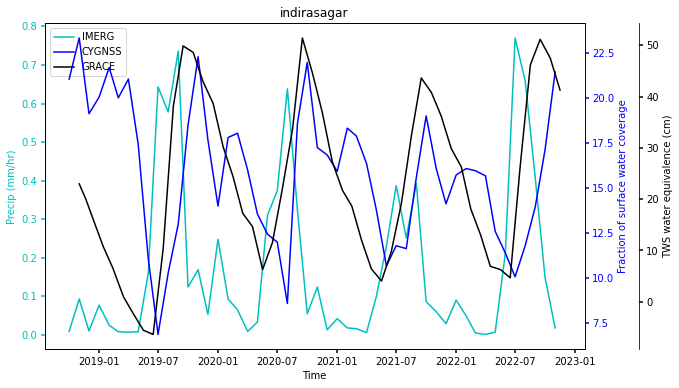

In [43]:
res_oi = 'indirasagar'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(res_coords_dict[res_oi],**plot_params)

           slope   intercept   r_value   p_value   std_err
labels                                                    
1426   -0.043903   88.705977 -0.039623  0.563379   0.07586
1427    -0.12197  245.336515 -0.117468  0.085735  0.070652
1428   -0.089652  180.387377 -0.093474  0.172064  0.065429
1429    0.247977 -496.908976  0.199375  0.003326  0.083511
1430    0.111738 -223.571149  0.096674  0.157785  0.078825


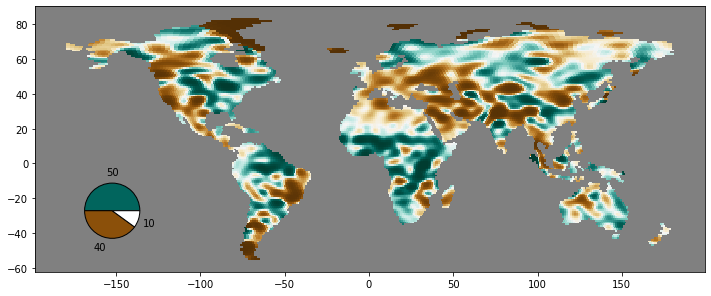

In [15]:
## Trying out plotting functionality

tws = grace_dict['cmwe'].T
x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
y_tws = tws
initial_tws_slopes = time_series_calcs.linregress_wrap(x_tws,y_tws)
print(initial_tws_slopes.head())

initial_tws_slopes_gdf = gpd.GeoDataFrame(pd.concat([initial_tws_slopes , grace_dict['mascon']],axis=1))

fig , ax = plt.subplots(figsize=(12,8))
input_gdf = initial_tws_slopes_gdf
count = 0
plotting_functions.statsig_map(input_gdf,ax,count, pie_row = [0.5,0.4,0.1])

In [19]:
coords_oi = res_coords_dict['estreito']
test = grace_point_subset(coords_oi)
print(test[1].iloc[0]['geometry'].exterior)
test[1]['geometry'].explore()

LINEARRING (-46.38655460000002 -6.5, -46.38655460000002 -7.5, -47.39495800000002 -7.5, -47.39495800000002 -6.5, -46.38655460000002 -6.5)


In [36]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
precip_ts = precip_series
fw_ts = fw_series
cmwe_ts = cmwe_series
precip_ts.index = list(map(toYearFraction,precip_ts.index))
fw_ts.index = list(map(toYearFraction,fw_ts.index))
cmwe_ts.index = list(map(toYearFraction,cmwe_ts.index))

In [37]:
precip_ts = time_series_calcs.TimeSeriesMetrics(precip_ts,'IMERG')
fw_ts = time_series_calcs.TimeSeriesMetrics(fw_ts,'CYGNSS')
cmwe_ts = time_series_calcs.TimeSeriesMetrics(cmwe_ts,'GRACE')

---coef of determination----
Between IMERG and CYGNSS
-311.1120714032106
---coef of determination----
Between IMERG and GRACE
-5241.484921902364
---coef of determination----
Between CYGNSS and IMERG
-0.08242628308416733
---coef of determination----
Between CYGNSS and GRACE
-16.829725985132992
---coef of determination----
Between GRACE and IMERG
0.01024049505463076
---coef of determination----
Between GRACE and CYGNSS
0.029379640492621317


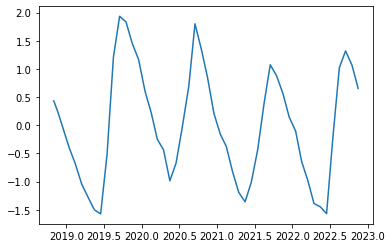

In [38]:
fig , ax = plt.subplots()
cmwe_ts.plot_anomalies(ax=ax)
precip_ts.coef_determination(fw_ts)
precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);